In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import graph_util, graph_io

import lucid.modelzoo.vision_models as models
from lucid.misc.io import show
from lucid.optvis import objectives, param, render, transform
import matplotlib.pyplot as plt



512 1181.7



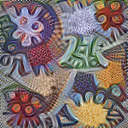

In [2]:
### Sanity check for lucid_tests install
model = models.InceptionV1()
model.load_graphdef()

# rendered
_ = render.render_vis(model, 'mixed4a_pre_relu:476')

# plt.imshow(rendered)



### Import custom model


Needs to import TF-trained model _graph definition_ and _checkpoint_ files

#### If importing a keras model:

In [3]:
# Load keras model
base_folder = '/Users/ricardobarroslourenco/PycharmProjects/clouds_rdcep/experimental/m19/'
with open((base_folder+'ae.json'), 'r') as file:
    k_model = tf.keras.models.model_from_json(file.read())
k_model.load_weights(base_folder+'ae.h5')

In [4]:
# Convert keras model object to a TF model object
num_output = 1 # Number of outputs (Default = 1). 
pred = [None]*num_output
pred_node_names = [None]*num_output
()
# with open((base_folder+'ae.tf_graphdef'), 'rb' )as file:
#     graph_def.ParseFromString(file.read())
# for node in graph_def.node:
#     print(node.name)
for i in range(num_output):
    pred_node_names[i] = 'output_node'+str(i)
    pred[i] = tf.identity(k_model.outputs[i], name=pred_node_names[i])

print("Output node names are: ", pred_node_names)

sess = tf.keras.backend.get_session()
tf.train.write_graph(sess.graph.as_graph_def(), base_folder, 'ae.tf_graphdef' , as_text=True)
print('Saved graph definition in ascii format at: '+base_folder+'ae.tf_graphdef')

Output node names are:  ['output_node0']
Saved graph definition in ascii format at: /Users/ricardobarroslourenco/PycharmProjects/clouds_rdcep/experimental/m19/ae.tf_graphdef


In [5]:
# Export weights
constant_graph = graph_util.convert_variables_to_constants(sess, sess.graph.as_graph_def(), pred_node_names)
graph_io.write_graph(constant_graph, base_folder, 'ae.tf_weights')
print('Saved TF graph at: '+base_folder+'ae.tf_weights')

INFO:tensorflow:Froze 12 variables.


INFO:tensorflow:Froze 12 variables.


Converted 12 variables to const ops.
Saved TF graph at: /Users/ricardobarroslourenco/PycharmProjects/clouds_rdcep/experimental/m19/ae.tf_weights


### Load trained model to Lucid

In [6]:
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph
    
frozen_graph = freeze_session(sess, output_names=pred_node_names)
tf.train.write_graph(frozen_graph, base_folder, 'ae_tf_frozen.modelzoo', as_text=False)

INFO:tensorflow:Froze 26 variables.


INFO:tensorflow:Froze 26 variables.


Converted 26 variables to const ops.


'/Users/ricardobarroslourenco/PycharmProjects/clouds_rdcep/experimental/m19/ae_tf_frozen.modelzoo'

#### Inspect output node name for graph freeze

In [7]:
from lucid.modelzoo.vision_base import Model

In [8]:
class m19model(Model):
    model_path = (base_folder+'ae_tf_frozen.modelzoo')
    image_shape = [64, 64, 3]
    image_value_range = (0, 1)
    input_name = 'ae_input'
    

In [9]:
m19lucid = m19model()
m19lucid.load_graphdef()

Display layers:

In [11]:
for node in m19lucid.graph_def.node:
  #if 'Concat' in node.op:
    print(node.name)

ae_input
conv2d/kernel
conv2d/kernel/read
conv2d/bias
conv2d/bias/read
conv2d/Conv2D
conv2d/BiasAdd
conv2d/Relu
conv2d_1/kernel
conv2d_1/kernel/read
conv2d_1/bias
conv2d_1/bias/read
conv2d_1/Conv2D
conv2d_1/BiasAdd
conv2d_1/Relu
conv2d_2/kernel
conv2d_2/kernel/read
conv2d_2/bias
conv2d_2/bias/read
conv2d_2/Conv2D
conv2d_2/BiasAdd
conv2d_2/Relu
conv2d_3/kernel
conv2d_3/kernel/read
conv2d_3/bias
conv2d_3/bias/read
conv2d_3/Conv2D
conv2d_3/BiasAdd
conv2d_3/Relu
conv2d_4/kernel
conv2d_4/kernel/read
conv2d_4/bias
conv2d_4/bias/read
conv2d_4/Conv2D
conv2d_4/BiasAdd
conv2d_4/Relu
conv2d_5/kernel
conv2d_5/kernel/read
conv2d_5/bias
conv2d_5/bias/read
conv2d_5/Conv2D
conv2d_5/BiasAdd
conv2d_5/Relu
conv2d_6/kernel
conv2d_6/bias
conv2d_transpose/kernel
conv2d_transpose/bias
conv2d_7/kernel
conv2d_7/bias
conv2d_transpose_1/kernel
conv2d_transpose_1/bias
conv2d_8/kernel
conv2d_8/bias
conv2d_transpose_2/kernel
conv2d_transpose_2/bias
reconstructed/kernel
reconstructed/bias
output_node0


512 1352.41



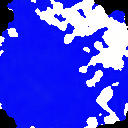

In [12]:
_  = render.render_vis(m19lucid, 'conv2d_5/Conv2D:0')